1. create folder in local runtime
2. upload dataset zip to local runtime
3. unzip

In [ ]:
!unzip /content/dataset_cropped_224x224_newest.zip -d /content/dataset_cropped_224x224_newest

Archive:  /content/dataset_cropped_224x224_newest-20251201T085041Z-1-001.zip
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/valid/c--77-_jpg.rf.d0757ba2fd080cc2bf7eabe8c1ede585_tile3.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/valid/c--145-_jpg.rf.d425c871d9e607c5d9f40e841669de0e_tile2.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/valid/c--30-_jpg.rf.dc31d1c1b3a5e0297ea8625cda59cf97_tile0.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/valid/c--37-_jpg.rf.c56cab6f013e88f18752b5cc3d23d7ba_tile0.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/valid/c--189-_jpg.rf.c7d7837efd4cc648da132594b3d9d0bc_tile3.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/valid/c--98-_jpg.rf.dc4bb77820fa1868fd06673f8f9acb94_tile3.jpg  
  inflating: /content/datas

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 11.0 MB/s eta 0:00:00


In [ ]:
import os
import time
import torch
import cv2
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

import albumentations as A
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
thop_available = False
try:
    # Check if thop is installed, if not, install it
    import importlib.util
    if not importlib.util.find_spec("thop"):
        print("Installing thop...")
        !pip install thop
        import thop # Re-import after installation attempt
    from thop import profile
    thop_available = True
except Exception as e:
    print(f"THOP library import failed: {e}")
    thop_available = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class MicroplasticsDataset(Dataset):
    def __init__(self, df, images_dir, transforms=None):
        self.df = df
        self.images_dir = images_dir
        self.transforms = transforms
        self.image_files = df['filename'].unique().tolist()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        records = self.df[self.df['filename'] == img_file]
        boxes = records[['xmin','ymin','xmax','ymax']].values
        labels = records['label'].values

        if self.transforms:
            aug = self.transforms(image=img, bboxes=boxes, class_labels=labels)
            img = aug['image']
            boxes = aug['bboxes']
            labels = aug['class_labels']

        img_tensor = torch.from_numpy(img).permute(2,0,1).float() / 255.0
        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.int64)

        return img_tensor, {"boxes": boxes_tensor, "labels": labels_tensor}


def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

crop_train_dir = "/content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train"
crop_val_dir   = "/content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/valid"

train_df = pd.read_csv(os.path.join(crop_train_dir, "_annotations.csv"))
val_df   = pd.read_csv(os.path.join(crop_val_dir, "_annotations.csv"))

# encodings
unique_classes = sorted(train_df['class'].unique())
class_to_idx = {cls: idx+1 for idx, cls in enumerate(unique_classes)}

train_df["label"] = train_df["class"].map(class_to_idx)
val_df["label"]   = val_df["class"].map(class_to_idx)

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=30, p=0.5)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

train_dataset = MicroplasticsDataset(train_df, crop_train_dir, transforms=train_transforms)
val_dataset   = MicroplasticsDataset(val_df, crop_val_dir, transforms=None)

# Increased val_loader batch_size from 1 to 16 for faster validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  collate_fn=collate_fn, num_workers=1)
val_loader   = DataLoader(val_dataset,   batch_size=1,  shuffle=False, collate_fn=collate_fn, num_workers=1)

print(f"Loaded {len(train_dataset)} train and {len(val_dataset)} validation images.")

Using device: cuda
Loaded 1869 train and 647 validation images.


In [ ]:
import os

train_files_fs = [f for f in os.listdir(crop_train_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
val_files_fs   = [f for f in os.listdir(crop_val_dir)   if f.lower().endswith((".jpg", ".png", ".jpeg"))]

print("train images on disk:", len(train_files_fs))
print("val images on disk:",   len(val_files_fs))
print("total on disk:",        len(train_files_fs) + len(val_files_fs))

print("train in CSV:", train_df["filename"].nunique())
print("val in CSV:",   val_df["filename"].nunique())

train images on disk: 2308
val images on disk: 816
total on disk: 3124
train in CSV: 1869
val in CSV: 647


# Model Setup

## CBAM Blocks

In [ ]:
from torchvision.ops import FeaturePyramidNetwork
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
try:
    import thop
    thop_available = True
except ImportError:
    thop_available = False

In [ ]:
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        # Channel Attention
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        x = x * self.sigmoid_channel(out)

        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_out = torch.cat([avg_out, max_out], dim=1)
        spatial_out = self.conv_spatial(spatial_out)
        x = x * self.sigmoid_spatial(spatial_out)
        return x

In [ ]:
class CustomCNNBackboneCBAM(nn.Module):
    def __init__(self, channels=(32, 64, 128, 256), reduction=16):
        super().__init__()
        in_ch = 3
        # Use simple naming so BackboneWithFPN works
        for i, out_ch in enumerate(channels):
            stride = 2 if i > 0 else 1
            block = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.SiLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.SiLU(inplace=True),
                CBAM(out_ch, reduction=reduction)
            )
            # Register as self.layer0, self.layer1...
            self.add_module(f"layer{i}", block)
            in_ch = out_ch
        self.out_channels = channels[-1]

    def forward(self, x):
        # Pass through all registered layers
        for name, module in self.named_children():
            x = module(x)
        return x

In [ ]:
def build_cbam_fpn_model(channels, reduction):
    backbone_base = CustomCNNBackboneCBAM(channels=channels, reduction=reduction)

    # We grab layers 1, 2, 3 (which are strides 4, 8, 16)
    # At 224 input, feature map sizes are: 56x56, 28x28, 14x14
    return_layers = {'layer1': '0', 'layer2': '1', 'layer3': '2'}

    backbone = BackboneWithFPN(
        backbone_base,
        return_layers=return_layers,
        in_channels_list=[channels[1], channels[2], channels[3]],
        out_channels=256
    )

    # ADJUSTED ANCHORS FOR 224x224
    # FPN outputs 4 levels (3 backbone + 1 pool).
    # Sizes must be 4 tuples.
    # Since image is small (224), we use smaller anchors: 16, 32, 64, 128
    anchor_generator = AnchorGenerator(
        sizes=((16,), (32,), (64,), (128,)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 4,
    )

    model = FasterRCNN(
        backbone,
        num_classes=len(unique_classes)+1,
        rpn_anchor_generator=anchor_generator,
        min_size=224, # Reverted to 224
        max_size=224, # Reverted to 224
        image_mean=[0.0, 0.0, 0.0],
        image_std=[1.0, 1.0, 1.0],
    ).to(device)

    return model

In [ ]:
def run_cbam_experiment(channels=(32, 64, 128, 256),
                      cbam_reduction=16,
                      num_epochs=30,
                      tag="customcnn_cbam_fpn"):

    # Clear cache before building
    torch.cuda.empty_cache()

    model = build_cbam_fpn_model(channels=channels, reduction=cbam_reduction)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    metric = MeanAveragePrecision().to(device)

    history = []
    print(f"\nExperiment {tag}, channels={channels}, CBAM reduction={cbam_reduction}")
    train_start_time = time.time()

    base_results_dir = "/models"
    os.makedirs(base_results_dir, exist_ok=True)
    experiment_dir = os.path.join(base_results_dir, tag)
    os.makedirs(experiment_dir, exist_ok=True)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0
        for images, targets in train_loader:
            images  = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            losses = model(images, targets)
            total_loss = sum(losses.values())
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()

        scheduler.step()
        epoch_loss_avg = epoch_loss / len(train_loader)

        model.eval()
        metric.reset()
        with torch.no_grad():
            for images, targets in val_loader:
                images  = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                preds = model(images)
                metric.update(preds, targets)

        m = metric.compute()
        map_50    = float(m["map_50"])
        map_50_95 = float(m["map"])

        history.append({
            "epoch": epoch, "loss": epoch_loss_avg,
            "mAP_50": map_50, "mAP_50_95": map_50_95,
        })

        print(f"Epoch {epoch:02d}: loss={epoch_loss_avg:.4f}, mAP@50={map_50:.3f}, mAP@50:95={map_50_95:.3f}")

    torch.save(model.state_dict(), os.path.join(experiment_dir, f"{tag}_final.pth"))
    total_time = time.time() - train_start_time
    print(f"Training completed in {total_time/60:.2f} min.")

    df_hist = pd.DataFrame(history)
    df_hist.to_csv(os.path.join(experiment_dir, f"{tag}_history.csv"), index=False)

    # Clean memory before MACs
    torch.cuda.empty_cache()

    macs = None
    if thop_available:
        try:
            from thop import profile
            model.eval()
            dummy_input = torch.randn(1, 3, 224, 224).to(device)
            macs, _ = profile(model, inputs=(dummy_input,), verbose=False)
        except Exception: macs = None

    total_params = sum(p.numel() for p in model.parameters())

    # Inference Speed
    inf_start = time.time()
    total_imgs = 0
    with torch.no_grad():
        for images, _ in val_loader:
            images = [img.to(device) for img in images]
            _ = model(images)
            total_imgs += len(images)
    avg_inf = (time.time() - inf_start) / max(total_imgs, 1)

    summary = {
        "model_tag": tag, "channels": channels, "cbam_reduction": cbam_reduction,
        "best_mAP_50": float(df_hist["mAP_50"].max()),
        "inference_time_sec": avg_inf, "FPS": 1.0/avg_inf if avg_inf > 0 else 0,
        "MACs_G": macs/1e9 if macs else None, "params_M": total_params/1e6
    }

    # Final cleanup
    del model
    torch.cuda.empty_cache()
    return df_hist, summary

In [ ]:
cbam_configs = [4, 8, 16]
cbam_summaries = []

for r in cbam_configs:
    tag = f"customcnn_cbam_fpn_r{r}"
    try:
        df_hist, summary = run_cbam_experiment(
            channels=(32, 64, 128, 256),
            cbam_reduction=r,
            num_epochs=30,
            tag=tag,
        )
        cbam_summaries.append(summary)
    except Exception as e:
        print(f"Experiment {tag} failed: {e}")
        torch.cuda.empty_cache()

df_cbam_results = pd.DataFrame(cbam_summaries)
print(df_cbam_results)


Experiment customcnn_cbam_fpn_r4, channels=(32, 64, 128, 256), CBAM reduction=4
Epoch 01: loss=0.5544, mAP@50=0.303, mAP@50:95=0.081
Epoch 02: loss=0.4930, mAP@50=0.337, mAP@50:95=0.105
Epoch 03: loss=0.4644, mAP@50=0.486, mAP@50:95=0.162
Epoch 04: loss=0.4429, mAP@50=0.468, mAP@50:95=0.154
Epoch 05: loss=0.4339, mAP@50=0.366, mAP@50:95=0.125
Epoch 06: loss=0.4304, mAP@50=0.536, mAP@50:95=0.186
Epoch 07: loss=0.4225, mAP@50=0.557, mAP@50:95=0.199
Epoch 08: loss=0.4192, mAP@50=0.581, mAP@50:95=0.213
Epoch 09: loss=0.4136, mAP@50=0.560, mAP@50:95=0.211
Epoch 10: loss=0.4069, mAP@50=0.623, mAP@50:95=0.235
Epoch 11: loss=0.4036, mAP@50=0.661, mAP@50:95=0.268
Epoch 12: loss=0.3859, mAP@50=0.647, mAP@50:95=0.263
Epoch 13: loss=0.3822, mAP@50=0.650, mAP@50:95=0.271
Epoch 14: loss=0.3807, mAP@50=0.663, mAP@50:95=0.273
Epoch 15: loss=0.3765, mAP@50=0.662, mAP@50:95=0.276
Epoch 16: loss=0.3757, mAP@50=0.660, mAP@50:95=0.277
Epoch 17: loss=0.3727, mAP@50=0.670, mAP@50:95=0.282
Epoch 18: loss=0.3

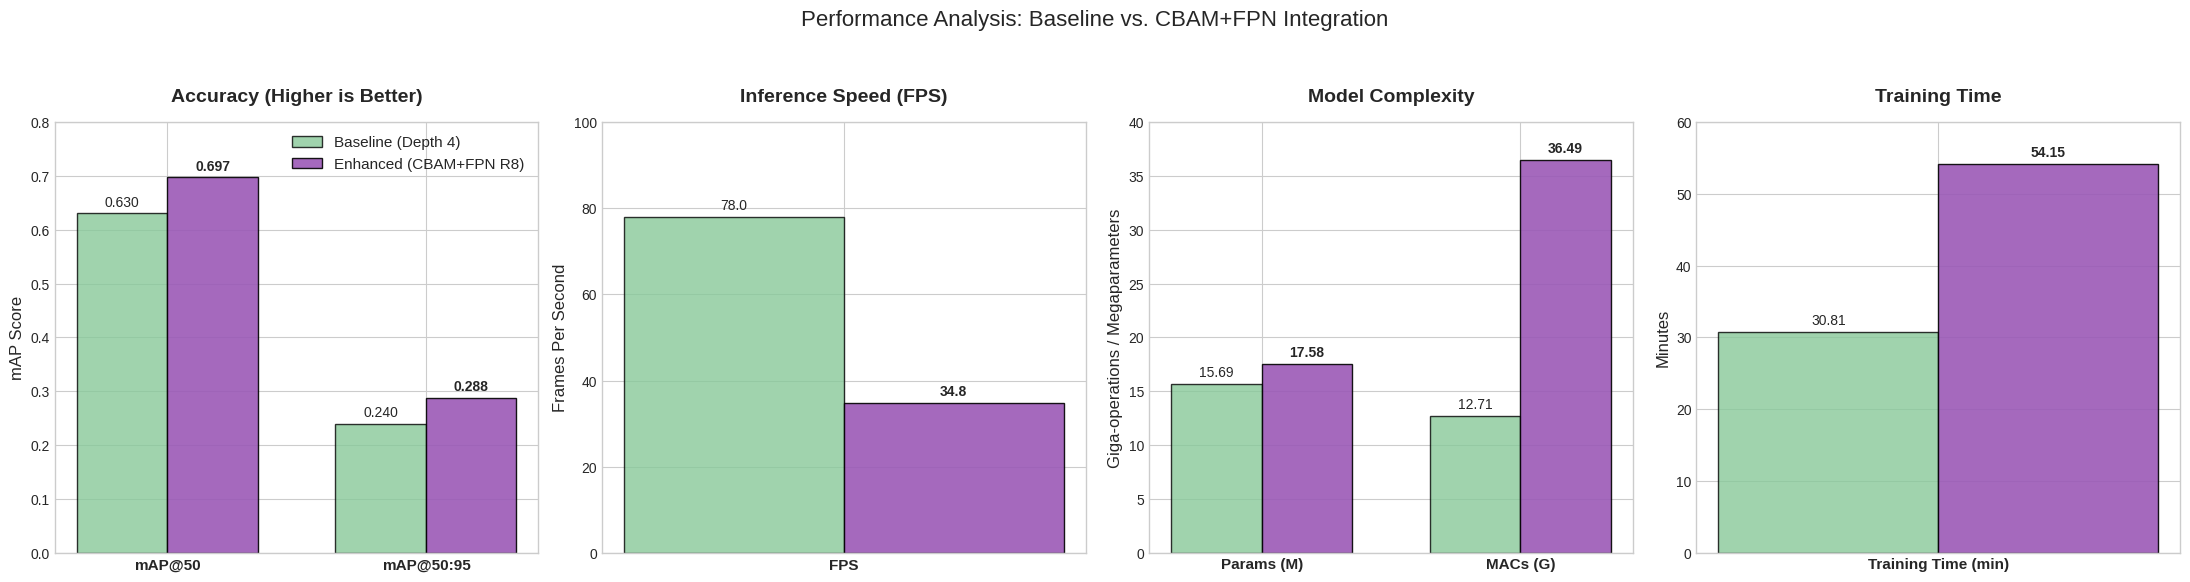

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# --- DATA PREPARATION ---
metrics = {
    'mAP@50':     {'Baseline': 0.63,   'Enhanced': 0.697},
    'mAP@50:95':  {'Baseline': 0.24,   'Enhanced': 0.288},
    'FPS':        {'Baseline': 78,     'Enhanced': 34.8},
    'Params (M)': {'Baseline': 15.69,  'Enhanced': 17.58},
    'MACs (G)':   {'Baseline': 12.71,  'Enhanced': 36.49},
    'Training Time (min)': {'Baseline': 30.81, 'Enhanced': 54.15}
}

# Grouping metrics for subplots (4 groups now)
groups = [
    ['mAP@50', 'mAP@50:95'],
    ['FPS'],
    ['Params (M)', 'MACs (G)'],
    ['Training Time (min)']
]

group_titles = [
    'Accuracy (Higher is Better)',
    'Inference Speed (FPS)',
    'Model Complexity',
    'Training Time'
]

# --- PLOTTING ---
fig, axes = plt.subplots(1, 4, figsize=(22, 5.5))
plt.style.use('seaborn-v0_8-whitegrid')

bar_width = 0.35
colors = ['#88c999', '#9b59b6']

for i, (ax, metric_group) in enumerate(zip(axes, groups)):

    x = np.arange(len(metric_group))
    baseline_vals = [metrics[m]['Baseline'] for m in metric_group]
    enhanced_vals = [metrics[m]['Enhanced'] for m in metric_group]

    # Create bars
    rects1 = ax.bar(x - bar_width/2, baseline_vals, bar_width, label='Baseline (Depth 4)', color=colors[0], edgecolor='black', alpha=0.8)
    rects2 = ax.bar(x + bar_width/2, enhanced_vals, bar_width, label='Enhanced (CBAM+FPN R8)', color=colors[1], edgecolor='black', alpha=0.9)

    # Formatting
    ax.set_title(group_titles[i], fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_group, fontsize=11, fontweight='bold')

    if i == 0:
        ax.legend(fontsize=11)

    # Specific Y-labeling and scale adjustment based on group index (i)
    if i == 0:
        ax.set_ylabel('mAP Score', fontsize=12)
        ax.set_ylim(0, 0.8)
        fmt_str = '%.3f'
    elif i == 1:
        ax.set_ylabel('Frames Per Second', fontsize=12)
        ax.set_ylim(0, 100)
        fmt_str = '%.1f'
    elif i == 2:
        ax.set_ylabel('Giga-operations / Megaparameters', fontsize=12)
        ax.set_ylim(0, 40)
        fmt_str = '%.2f'
    elif i == 3:
        ax.set_ylabel('Minutes', fontsize=12)
        ax.set_ylim(0, 60)
        fmt_str = '%.2f'

    # Add value labels
    ax.bar_label(rects1, padding=3, fmt=fmt_str, fontsize=10)
    ax.bar_label(rects2, padding=3, fmt=fmt_str, fontsize=10, fontweight='bold')

plt.suptitle('Performance Analysis: Baseline vs. CBAM+FPN Integration', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()